In [1]:
%config Completer.use_jedi = False

In [2]:
import sys
sys.path.append('/home/victorialena/rlkit')

import pdb

In [3]:
import dgl
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from copy import copy, deepcopy
from torch.optim import Adam

In [4]:
from env.job_shop import jobShopScheduling
from actor.job_shop import *
from utils.job_shop import * # custom replay buffer and episode sampler
from utils.jsp_makespan import *

from path_collector import MdpPathCollector

/home/victorialena/anaconda3/envs/rlpyt/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import MutableMapping
/home/victorialena/anaconda3/envs/rlpyt/lib/python3.7/site-packages/matplotlib/colors.py:53: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Sized


#### Helpers

In [5]:
scientific_notation =  lambda x:"{:.2e}".format(x)

def get_scores(g, scores):
    n = scores.shape[0]
    idx = (g.ndata['hv']['job'][:, 3] == 0).view(n, -1)
    
    values, workers = scores.max(-1, keepdims=False)
    return torch.stack([values[i][idx[i]].max() if sum(idx[i]).item()>0 else torch.tensor(0.) for i in range(n)])

def mean_reward(paths):
    return torch.tensor([p['rewards'] for p in paths]).sum(1).mean().item()

def mean_makespan(paths):
    "Returns the average makespan successful paths from given list. Returns *nan* if no path was successful."
    return torch.tensor([p['makespan'] for p in paths if p['success']]).mean().item()

def relative_makespan_error(paths):
    """From initial conditions of each path, evaluate optimal makespan for each path and compare against
    sampled trajectory. """
    err = []
    for p in paths:
        if not p['success']:
            continue
        jdata = g2jobdata(p['observations'][0], p['actions'])
        makespan, status = get_makespan(jdata)
        if makespan > -1: # feasible
            relative_error = p['makespan']/makespan - 1
            err.append(relative_error)
        else: 
            print("This should not be possible, check for bugs!!")
            
    return torch.tensor(err).mean().item()

#### Q Learning

In [6]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

In [7]:
njobs, nworkers = 25, 10 #10, 2 #5, 2
env = jobShopScheduling(njobs, nworkers)
g0 = env.reset()

In [8]:
qf = hgnn()
expl_policy = epsilonGreedyPolicy(qf, .1)

target_qf = hgnn()
eval_policy = epsilonGreedyPolicy(target_qf, 0.)

expl_path_collector = MdpPathCollector(env, expl_policy, rollout_fn=sample_episode, parallelize=False)
eval_path_collector = MdpPathCollector(env, eval_policy, rollout_fn=sample_episode, parallelize=False)

replay_buffer_cap = 5000 #10000
replay_buffer = replayBuffer(replay_buffer_cap, prioritized=True)

```python
path = rollout(env, expl_policy, 2500)
path['terminals'][-1]
env.render()

replay_buffer.add_path(path, env.g)

replay_buffer.random_batch(50)
```

In [9]:
learning_rate = 8e-5 #1e-4

In [10]:
optimizer = Adam(qf.parameters(), lr=learning_rate, weight_decay=0.01)
qf_criterion = nn.MSELoss()

max_len = njobs+1
n_samples = 128 
n_epoch = 300 #425 #300 #200
n_iter = 64
batch_size = 32
gamma = 1.0

loss = []
avg_r_train = []
avg_r_eval = []
success_rates = []
relative_errors = []

In [11]:
for i in range(n_epoch):
    qf.train(False)
    paths = expl_path_collector.collect_new_paths(n_samples, max_len, False)
    train_r = mean_reward(paths)
    avg_r_train.append(train_r)
    replay_buffer.add_paths(paths)
    
    paths = eval_path_collector.collect_new_paths(n_samples//4, max_len, False)
    eval_r = mean_reward(paths)
    avg_r_eval.append(eval_r)
    
    success_rate = np.mean([p['success'] for p in paths])
    success_rates.append(success_rate)
    
    avg_makespan = mean_makespan(paths)
    relative_err = relative_makespan_error(paths)
    relative_errors.append(relative_err)

    qf.train(True)
    if i==150:#200:
        expl_policy.eps = 0.05
        
    for _ in range(n_iter):
        batch = replay_buffer.random_batch(batch_size)

        rewards = torch.tensor([b.r for b in batch])
        terminals = torch.tensor([b.d for b in batch]).float()
        actions = torch.tensor([b.a for b in batch])
        
        states = batch_graphs([b.s for b in batch])
        next_s = batch_graphs([b.sp for b in batch])        

        out = target_qf(next_s) # shape = (|G|, |J|, |W|)
        target_q_values = get_scores(next_s, out)
        y_target = rewards + (1. - terminals) * gamma * target_q_values 
        
        out = qf(states)
        y_pred = out[torch.arange(batch_size), actions.T[1], actions.T[0]]
        qf_loss = qf_criterion(y_pred, y_target).to(torch.float)

        loss.append(qf_loss.item())

        optimizer.zero_grad()
        qf_loss.backward()
        optimizer.step()

    target_qf.load_state_dict(deepcopy(qf.state_dict()))
    err = 3
    print("Epoch", i+1, #"| lr:", scientific_notation(optimizer.param_groups[0]["lr"]) ,
          " -> Loss:", round(np.mean(loss[-n_iter:]), err),
          "| Rewards: (train)", round(train_r, err), "(test)", round(eval_r, err),
          "| Success rate:", round(success_rate, err), 
          "| Makespan:", round(avg_makespan, err), 
          "| Rel. error:", round(relative_err, err), )

/home/victorialena/anaconda3/envs/rlpyt/lib/python3.7/site-packages/dgl/heterograph.py:354: DGLWarning: DGLGraph.add_edge is deprecated. Please use DGLGraph.add_edges
  dgl_warning("DGLGraph.add_edge is deprecated. Please use DGLGraph.add_edges")


Epoch 1  -> Loss: 387.544 | Rewards: (train) 23.01 (test) -0.25 | Success rate: 0.0 | Makespan: nan | Rel. error: nan
Epoch 2  -> Loss: 358.048 | Rewards: (train) 19.742 (test) 20.62 | Success rate: 0.5 | Makespan: 40.462 | Rel. error: -0.221
Epoch 3  -> Loss: 327.875 | Rewards: (train) 9.706 (test) 9.8 | Success rate: 0.0 | Makespan: nan | Rel. error: nan
Epoch 4  -> Loss: 362.883 | Rewards: (train) 8.267 (test) 9.915 | Success rate: 0.0 | Makespan: nan | Rel. error: nan
Epoch 5  -> Loss: 41.778 | Rewards: (train) 1.523 (test) 0.274 | Success rate: 0.0 | Makespan: nan | Rel. error: nan
Epoch 6  -> Loss: 17.27 | Rewards: (train) 1.525 (test) 0.562 | Success rate: 0.0 | Makespan: nan | Rel. error: nan
Epoch 7  -> Loss: 5.657 | Rewards: (train) 1.455 (test) 0.303 | Success rate: 0.0 | Makespan: nan | Rel. error: nan
Epoch 8  -> Loss: 85.749 | Rewards: (train) 1.715 (test) 0.531 | Success rate: 0.0 | Makespan: nan | Rel. error: nan
Epoch 9  -> Loss: 17.951 | Rewards: (train) 2.893 (test) 

Epoch 71  -> Loss: 44.171 | Rewards: (train) 1.73 (test) 0.502 | Success rate: 0.0 | Makespan: nan | Rel. error: nan
Epoch 72  -> Loss: 44.46 | Rewards: (train) 0.792 (test) -0.25 | Success rate: 0.0 | Makespan: nan | Rel. error: nan
Epoch 73  -> Loss: 22.77 | Rewards: (train) 4.661 (test) 5.967 | Success rate: 0.062 | Makespan: 85.9 | Rel. error: 0.714
Epoch 74  -> Loss: 42.704 | Rewards: (train) 3.458 (test) 4.43 | Success rate: 0.031 | Makespan: 52.4 | Rel. error: 0.69
Epoch 75  -> Loss: 36.494 | Rewards: (train) 0.517 (test) -0.221 | Success rate: 0.0 | Makespan: nan | Rel. error: nan
Epoch 76  -> Loss: 27.578 | Rewards: (train) 9.911 (test) 10.88 | Success rate: 0.25 | Makespan: 49.9 | Rel. error: -0.136
Epoch 77  -> Loss: 14.159 | Rewards: (train) 4.78 (test) 3.456 | Success rate: 0.031 | Makespan: 57.4 | Rel. error: 0.305
Epoch 78  -> Loss: 8.33 | Rewards: (train) 1.571 (test) 1.215 | Success rate: 0.0 | Makespan: nan | Rel. error: nan
Epoch 79  -> Loss: 15.271 | Rewards: (train

Epoch 138  -> Loss: 1.898 | Rewards: (train) 19.478 (test) 20.847 | Success rate: 0.625 | Makespan: 53.1 | Rel. error: -0.175
Epoch 139  -> Loss: 1.699 | Rewards: (train) 20.463 (test) 20.515 | Success rate: 0.656 | Makespan: 46.59 | Rel. error: -0.137
Epoch 140  -> Loss: 1.677 | Rewards: (train) 20.644 (test) 22.562 | Success rate: 0.75 | Makespan: 37.9 | Rel. error: -0.234
Epoch 141  -> Loss: 1.16 | Rewards: (train) 19.571 (test) 22.349 | Success rate: 0.781 | Makespan: 37.8 | Rel. error: -0.231
Epoch 142  -> Loss: 1.377 | Rewards: (train) 20.715 (test) 22.477 | Success rate: 0.719 | Makespan: 41.27 | Rel. error: -0.248
Epoch 143  -> Loss: 1.366 | Rewards: (train) 19.968 (test) 21.657 | Success rate: 0.781 | Makespan: 38.96 | Rel. error: -0.179
Epoch 144  -> Loss: 1.32 | Rewards: (train) 21.548 (test) 20.946 | Success rate: 0.625 | Makespan: 49.2 | Rel. error: -0.154
Epoch 145  -> Loss: 1.329 | Rewards: (train) 19.879 (test) 20.767 | Success rate: 0.594 | Makespan: 48.084 | Rel. erro

Epoch 203  -> Loss: 1.132 | Rewards: (train) 22.345 (test) 23.102 | Success rate: 0.875 | Makespan: 37.579 | Rel. error: -0.32
Epoch 204  -> Loss: 1.26 | Rewards: (train) 22.779 (test) 21.595 | Success rate: 0.719 | Makespan: 40.748 | Rel. error: -0.29
Epoch 205  -> Loss: 1.316 | Rewards: (train) 22.874 (test) 23.591 | Success rate: 0.844 | Makespan: 38.289 | Rel. error: -0.303
Epoch 206  -> Loss: 1.304 | Rewards: (train) 23.075 (test) 23.636 | Success rate: 0.906 | Makespan: 33.331 | Rel. error: -0.345
Epoch 207  -> Loss: 1.146 | Rewards: (train) 22.146 (test) 23.48 | Success rate: 0.875 | Makespan: 40.721 | Rel. error: -0.316
Epoch 208  -> Loss: 1.155 | Rewards: (train) 22.645 (test) 24.176 | Success rate: 0.938 | Makespan: 29.2 | Rel. error: -0.356
Epoch 209  -> Loss: 0.971 | Rewards: (train) 22.581 (test) 23.505 | Success rate: 0.844 | Makespan: 33.993 | Rel. error: -0.33
Epoch 210  -> Loss: 1.05 | Rewards: (train) 23.011 (test) 23.41 | Success rate: 0.875 | Makespan: 44.971 | Rel.

Epoch 268  -> Loss: 1.199 | Rewards: (train) 23.582 (test) 24.07 | Success rate: 0.969 | Makespan: 38.013 | Rel. error: -0.335
Epoch 269  -> Loss: 1.231 | Rewards: (train) 23.707 (test) 23.597 | Success rate: 0.906 | Makespan: 32.297 | Rel. error: -0.415
Epoch 270  -> Loss: 1.258 | Rewards: (train) 23.447 (test) 23.802 | Success rate: 0.938 | Makespan: 39.1 | Rel. error: -0.368
Epoch 271  -> Loss: 1.175 | Rewards: (train) 23.702 (test) 24.021 | Success rate: 0.938 | Makespan: 38.533 | Rel. error: -0.366
Epoch 272  -> Loss: 1.53 | Rewards: (train) 23.737 (test) 23.532 | Success rate: 0.906 | Makespan: 27.055 | Rel. error: -0.458
Epoch 273  -> Loss: 1.84 | Rewards: (train) 23.929 (test) 24.206 | Success rate: 0.969 | Makespan: 35.303 | Rel. error: -0.393
Epoch 274  -> Loss: 1.258 | Rewards: (train) 22.864 (test) 23.371 | Success rate: 0.875 | Makespan: 31.114 | Rel. error: -0.413
Epoch 275  -> Loss: 1.992 | Rewards: (train) 23.631 (test) 24.001 | Success rate: 0.906 | Makespan: 30.848 | 

In [2]:
qf.eval()

NameError: name 'qf' is not defined

```python
g1 = env.reset()
qf.eval()
print(g1.edges(etype='precede'))
print(qf(g1))

g2, r, d, info = env2.step((0, 1))

# paths = eval_path_collector.collect_new_paths(10, 3)
```

#### Plot

In [12]:
import matplotlib.pyplot as plt

In [13]:
losses = [np.mean(loss[i*n_iter:(i+1)*n_iter]) for i in range(n_epoch)]

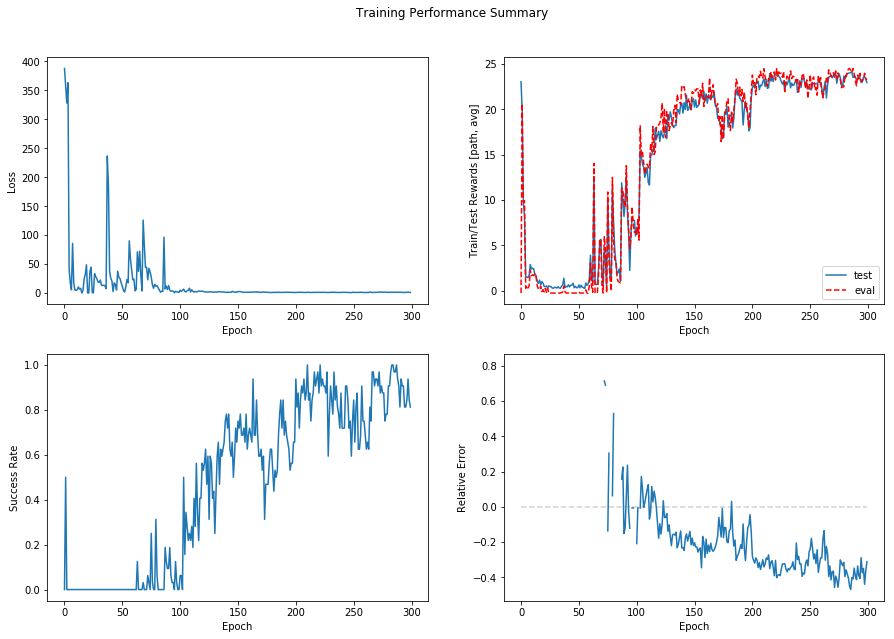

In [15]:
x = np.arange(n_epoch)

plt.figure(figsize=(15, 10))

plt.subplot(221)
plt.plot(x, losses)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.subplot(222)
plt.plot(x, avg_r_train, label="test")
plt.plot(x, avg_r_eval, 'r--', label="eval")
plt.legend()
plt.ylabel('Train/Test Rewards [path, avg]')
plt.xlabel('Epoch')
plt.subplot(223)
plt.plot(x, success_rates)
plt.ylabel('Success Rate')
plt.xlabel('Epoch')
plt.subplot(224)
plt.plot(x, [0.0]*len(x), 'lightgray', linestyle='--')
plt.plot(x, relative_errors)
plt.ylabel('Relative Error')
plt.xlabel('Epoch')
plt.suptitle('Training Performance Summary', y=.95)
plt.savefig('figs/job_shop/j%d-w%d_4x4_annealed' % (njobs, nworkers), dpi=300)

```python
plt.figure(figsize=(15, 4))

plt.subplot(131)
plt.plot(x, losses)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.subplot(132)
plt.plot(x, avg_r_train, label="test")
plt.plot(x, avg_r_eval, 'r--', label="eval")
plt.legend()
plt.ylabel('Train/Test Rewards [path, avg]')
plt.xlabel('Epoch')
plt.subplot(133)
plt.plot(x, success_rates)
plt.ylabel('Success Rate')
plt.xlabel('Epoch')
plt.suptitle('Training Performance Summary')
plt.savefig('figs/job_shop/j%d-w%d_hor' % (njobs, nworkers), dpi=300)
```

```python 
ylabels = ['Loss', 'Train/Test Rewards', 'Success Rate']

fig, axs = plt.subplots(3, 1, figsize=(6, 12))
plt.suptitle('Training Performance Summary', y=.92)
axs[0].plot(x, losses)
axs[1].plot(x, avg_r_train, label="train")
axs[1].plot(x, avg_r_eval, 'r--', label="eval")
axs[1].legend()
axs[2].plot(x, success_rates)

for label, ax in zip(ylabels, axs.flat):
    ax.set(xlabel='Epoch', ylabel=label)

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
plt.savefig('figs/job_shop/j%d-w%d_ver' % (njobs, nworkers), dpi=300)
```